In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os 

In [21]:
def LoadImages(folder): 
    images = [] 
    for filename in os.listdir(folder): 
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            img = cv2.imread(os.path.join(folder, filename)) 
            if img is not None: 
                images.append(img) 
    
    return images 

In [22]:
folder_path = "images"
Surface = "Surface"

In [23]:
def GetContours(img, 
                  GaussianKernel : tuple = (5, 5),
                  median : int = 21,
                  MorphologyKernel : tuple = (5,5),
                  CannyThreshold_min : int = 50,
                  CannyThreshold_max : int = 100):
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_blur = cv2.GaussianBlur(img_gray, GaussianKernel, 0)

    img_filtered = cv2.medianBlur(img_blur, median)

    img_morph = cv2.morphologyEx(img_filtered, cv2.MORPH_OPEN, MorphologyKernel) 
    img_morph = cv2.morphologyEx(img_morph, cv2.MORPH_CLOSE, MorphologyKernel)

    edges = cv2.Canny(img_morph,
                      CannyThreshold_min,
                      CannyThreshold_max)

    return cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [24]:
def ShowContoursOnly(img, Surface, contours):
    zero = np.zeros_like(img)

    cv2.drawContours(zero, contours, -1, (0,255,0), 1)
    cv2.imshow(Surface, zero)

In [25]:
def MyShowContours(img, Surface, contours):
    for i, contour in enumerate(contours): 
        img_copy = img.copy()    
        
        cv2.drawContours(img_copy, [contour], -1, (0, 255, 0), 2) 
        print(f"{cv2.contourArea(contour) = }")
        print(f"{cv2.arcLength(contour, True) = }")
        print(f"{cv2.arcLength(contour, False) = }")

        plt.imshow(img_copy) 
        plt.axis('off') 
        plt.title('Image Display') 
        plt.show()

In [26]:
def is_circle(contour, center, radius):
    distances = [cv2.norm(point[0] - np.array(center)) for point in contour]
    mean_distance = np.mean(distances)
    variance = np.var(distances)

    return variance < (0.01 * mean_distance ** 2)

In [27]:
def classify_shape(img, contours):
    img_copy = img.copy()
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))

        cv2.drawContours(img_copy, [contour], -1, (0,0,0), 2) 
        # Determine the shape
        if len(approx) == 3:
            cv2.drawContours(img_copy, [contour], -1, (255,0,0), 2) 
        elif len(approx) == 4:
            cv2.drawContours(img_copy, [contour], -1, (0,255,0), 2) 
        elif is_circle(contour, center, radius):
            cv2.drawContours(img_copy, [contour], -1, (0,0,255), 2) 
        else:
            cv2.drawContours(img_copy, [contour], -1, (255,255,0), 2) 
        
    plt.imshow(img_copy) 
    plt.axis('off') 
    plt.title('Image Display') 
    plt.show()



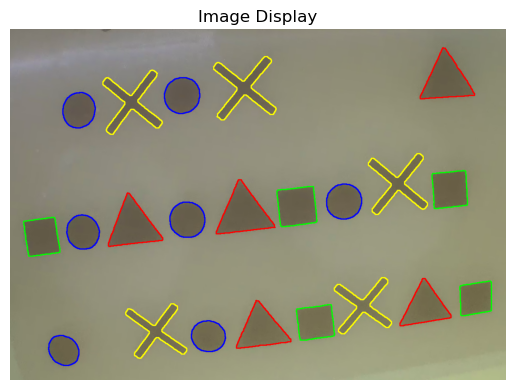

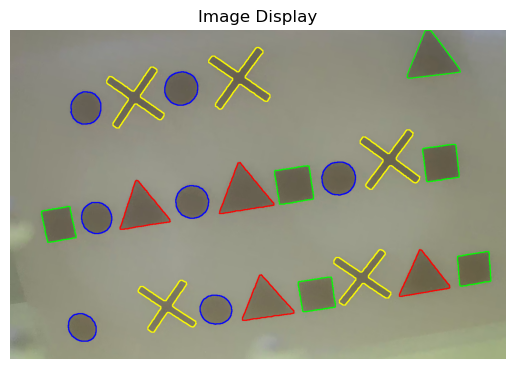

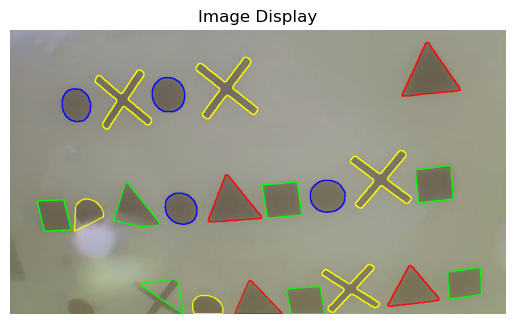

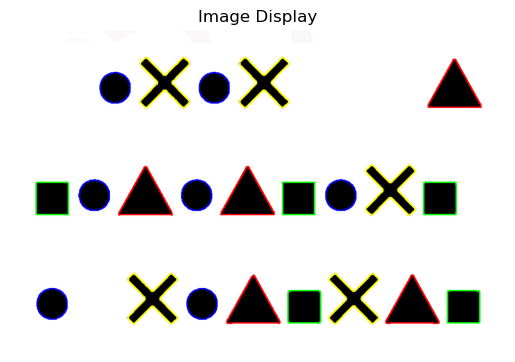

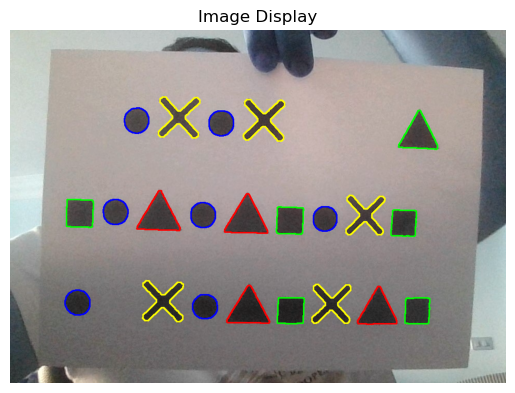

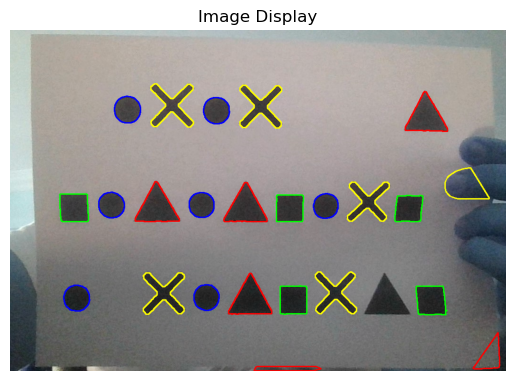

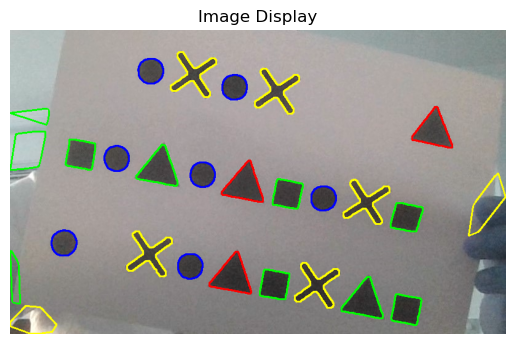

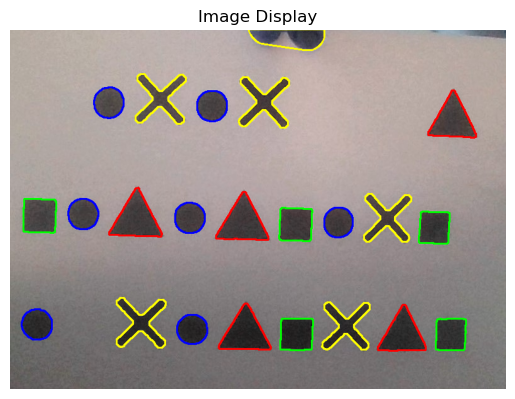

In [28]:
for img in LoadImages(folder_path):
    img_filtered = cv2.medianBlur(img, 5) 

    sharpening_kernel = np.array([[-1, -1, -1], 
                                  [-1, 9, -1], 
                                  [-1, -1, -1]]) 
    
    img_sharpened = cv2.filter2D(img_filtered, -1, sharpening_kernel) 

    img_gray = cv2.cvtColor(img_sharpened, cv2.COLOR_BGR2GRAY) 

    img_blur = cv2.GaussianBlur(img_gray, (5,5), 0) 

    MorphologyKernel = np.ones((5,5), np.uint8) 
    img_morph = cv2.morphologyEx(img_blur, cv2.MORPH_CLOSE, MorphologyKernel) 
    img_morph = cv2.morphologyEx(img_morph, cv2.MORPH_OPEN, MorphologyKernel) 

    edges = cv2.Canny(img_morph, 50, 100) 

    kernel = np.ones((5, 5), np.uint8) 
    closed_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel) 

    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    MeanArea = np.mean([cv2.contourArea(contour) for contour in contours])
    MedianArea = np.median([cv2.contourArea(contour) for contour in contours])

    criteria = MedianArea if MedianArea > MeanArea else MeanArea
    criteria *= 0.5

    filter_By_Area_contours = [] 
    for contour in contours: 
        if cv2.contourArea(contour) > criteria: 
            filter_By_Area_contours.append(contour) 
        else: 
            hull = cv2.convexHull(contour) 
            if cv2.contourArea(hull) > criteria: 
                filter_By_Area_contours.append(hull)

    filter_By_ArcLength_contours = [contour for contour in filter_By_Area_contours if cv2.arcLength(contour,False) < cv2.contourArea(contour)*0.4]

    filtered_contours = [contour for contour in filter_By_ArcLength_contours if cv2.contourArea(contour) < criteria*4] 

    classify_shape(img, filtered_contours)